In [1]:
!pip install datasets transformers evaluate
!pip install huggingface_hub
!pip install jiwer
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
import os
import torch
import torchaudio
from datasets import load_dataset, concatenate_datasets, Audio
import pandas as pd
import numpy as np
from transformers import WhisperProcessor, WhisperForConditionalGeneration, AutoConfig, BitsAndBytesConfig
import evaluate
from bitsandbytes.nn import Int8Params, Params4bit
import torch.nn.utils.prune as prune


In [ ]:
# from huggingface_hub import notebook_login

# # This will display a widget to login interactively
# notebook_login()

In [ ]:
import pandas as pd
from datasets import load_dataset

def get_balanced_sample(lang_code, max_samples=500):
    """Get a small gender-balanced sample for a language"""

    # Load dataset in streaming mode
    stream_dataset = load_dataset("mozilla-foundation/common_voice_13_0", lang_code, split="validation", streaming=True)

    # Filter samples with gender info
    filtered_dataset = (x for x in stream_dataset if x["gender"] in ["male", "female"])

    # Collect up to max_samples items
    dataset = []
    for sample in filtered_dataset:
        if len(dataset) >= max_samples:
            break
        dataset.append(sample)

    # Separate by gender
    male_samples = [x for x in dataset if x["gender"] == "male"]
    female_samples = [x for x in dataset if x["gender"] == "female"]

    # Get balanced samples (up to max_samples/2 from each gender)
    max_per_gender = min(len(male_samples), len(female_samples), max_samples // 2)

    male_balanced = male_samples[:max_per_gender]
    female_balanced = female_samples[:max_per_gender]

    # Combine and return
    results = {
        "male": male_balanced,
        "female": female_balanced
    }

    print(f"{lang_code}: Got {len(male_balanced)} male and {len(female_balanced)} female samples")
    return results

# Test with a few languages
languages = ["en", "es", "fr"]
languages = ["en"]
samples = {}

for lang in languages:
    samples[lang] = get_balanced_sample(lang)


Reading metadata...: 16372it [00:00, 40280.92it/s]


en: Got 74 male and 74 female samples


In [ ]:
# from datasets import load_dataset

# def prepare_gender_balanced_data_streaming(lang_code, max_samples=200):
#     """Create a gender-balanced dataset in streaming mode."""
#     dataset = load_dataset("mozilla-foundation/common_voice_13_0", lang_code, split="validation", streaming=True)

#     # Filter samples with gender info
#     filtered_dataset = (x for x in dataset if x["gender"] in ["male", "female"])

#     # Collect up to max_samples items
#     male_samples, female_samples = [], []

#     for sample in filtered_dataset:
#         if sample["gender"] == "male" and len(male_samples) < max_samples // 2:
#             male_samples.append(sample)
#         elif sample["gender"] == "female" and len(female_samples) < max_samples // 2:
#             female_samples.append(sample)

#         if len(male_samples) >= max_samples // 2 and len(female_samples) >= max_samples // 2:
#             break  # Stop collecting once balanced

#     print(f"{lang_code}: {len(male_samples)} male, {len(female_samples)} female samples")

#     return {
#         "male": male_samples,
#         "female": female_samples,
#         "combined": male_samples + female_samples
#     }

# # Example usage
# languages = ["en", "es", "fr"]
# balanced_datasets = {lang: prepare_gender_balanced_data_streaming(lang) for lang in languages}


Reading metadata...: 16372it [00:00, 73367.14it/s]


en: 100 male, 100 female samples


Reading metadata...: 15708it [00:00, 67465.52it/s]


KeyboardInterrupt: 

In [13]:
from bitsandbytes.nn import Int8Params, Params4bit

# Load Whisper model (small to start with, as in the paper)
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS on macOS
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA on compatible GPUs
else:
    device = torch.device("cpu")  # Default to CPU

print(f"Using device: {device}")

model_id = "openai/whisper-small"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define precision options
fp_precision = "8bit"  # Change to "8bit", "4bit", or "32bit" as needed
precision_map = {
    "32bit": torch.float32,
    "16bit": torch.float16,
    "bf16": torch.bfloat16
}

# Load processor
processor = WhisperProcessor.from_pretrained(model_id)

if torch.backends.mps.is_available() and fp_precision in ["8bit", "4bit"]:
    raise ValueError("bitsandbytes 8-bit and 4-bit quantization is not supported on Apple MPS. Please use '16bit' or '32bit' instead.")

# Handle 8-bit and 4-bit quantization separately
if fp_precision in ["8bit", "4bit"]:
    use_4bit = fp_precision == "4bit"
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=use_4bit,
        load_in_8bit=not use_4bit,
        bnb_4bit_compute_dtype=torch.float16 if use_4bit else None,
        bnb_4bit_use_double_quant=use_4bit
    )

    # Load model with quantization
    model = WhisperForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=quantization_config
    )
else:
    # Load model with specified precision
    torch_dtype = precision_map.get(fp_precision, torch.float32)
    model = WhisperForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch_dtype
    )

# Move to device if not quantized (bnb models stay on GPU automatically)
if fp_precision not in ["8bit", "4bit"]:
    model = model.to(device)

print(f"Model loaded with {fp_precision} precision on {device}")
# print(f"Precision: {precision}")
print(f"Model dtype after loading: {next(model.parameters()).dtype}")

# Print details about quantized layers
for name, param in model.named_parameters():
    if isinstance(param, (Int8Params, Params4bit)):
        print(f"Layer {name} is quantized with {type(param)}")

print(f"Memory allocated: {torch.cuda.memory_allocated() / 1e6} MB")
print(f"Device: {device}")

import torch.nn.utils.prune as prune
from transformers import BitsAndBytesConfig

def apply_magnitude_pruning(model, amount=0.3, fp_precision="16bit"):
    """Apply magnitude pruning to Conv and Linear layers, maintaining precision."""
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv1d) or isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            # Make pruning permanent
            prune.remove(module, 'weight')

            # Ensure weight remains in the correct precision
            if fp_precision == "16bit":
                module.weight.data = module.weight.data.to(torch.float16)
            elif fp_precision == "8bit" or fp_precision == "4bit":
                module.weight.data = module.weight.data.to(torch.float32)  # BnB handles quantization itself

    return model

pruning_levels = [0, 0.3, 0.5]  # 0 means original model
pruned_models = {}

for level in pruning_levels:
    if level == 0:
        pruned_models[level] = model
    else:
        print(f"Creating pruned model with {level*100}% pruning...")

        if fp_precision in ["8bit", "4bit"]:
            use_4bit = fp_precision == "4bit"
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=use_4bit,
                load_in_8bit=not use_4bit,
                bnb_4bit_compute_dtype=torch.float16 if use_4bit else None,
                bnb_4bit_use_double_quant=use_4bit
            )

            # Reload in quantized format
            pruned_models[level] = WhisperForConditionalGeneration.from_pretrained(
                model_id,
                quantization_config=quantization_config
            )
        else:
            # Reload in correct precision (FP16 or FP32)
            torch_dtype = torch.float16 if fp_precision == "16bit" else torch.float32
            pruned_models[level] = WhisperForConditionalGeneration.from_pretrained(
                model_id,
                torch_dtype=torch_dtype
            ).to(device)

        # Apply pruning while keeping precision
        pruned_models[level] = apply_magnitude_pruning(pruned_models[level], amount=level, fp_precision=fp_precision)

        # Ensure model remains in the correct precision
        if fp_precision == "16bit":
            pruned_models[level] = pruned_models[level].half().to(device)

        print(f"Model dtype after pruning: {next(pruned_models[level].parameters()).dtype}")
        # print(f"Memory allocated: {torch.cuda.memory_allocated() / 1e6} MB")



Using device: cuda


`low_cpu_mem_usage` was None, now default to True since model is quantized.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Model loaded with 8bit precision on cuda
Model dtype after loading: torch.float16
Layer model.encoder.layers.0.self_attn.k_proj.weight is quantized with <class 'bitsandbytes.nn.modules.Int8Params'>
Layer model.encoder.layers.0.self_attn.v_proj.weight is quantized with <class 'bitsandbytes.nn.modules.Int8Params'>
Layer model.encoder.layers.0.self_attn.q_proj.weight is quantized with <class 'bitsandbytes.nn.modules.Int8Params'>
Layer model.encoder.layers.0.self_attn.out_proj.weight is quantized with <class 'bitsandbytes.nn.modules.Int8Params'>
Layer model.encoder.layers.0.fc1.weight is quantized with <class 'bitsandbytes.nn.modules.Int8Params'>
Layer model.encoder.layers.0.fc2.weight is quantized with <class 'bitsandbytes.nn.modules.Int8Params'>
Layer model.encoder.layers.1.self_attn.k_proj.weight is quantized with <class 'bitsandbytes.nn.modules.Int8Params'>
Layer model.encoder.layers.1.self_attn.v_proj.weight is quantized with <class 'bitsandbytes.nn.modules.Int8Params'>
Layer model.en

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Model dtype after pruning: torch.float16


In [ ]:
import torch
import torchaudio
import pandas as pd
import evaluate

# Load Word Error Rate metric
wer_metric = evaluate.load("wer")

def resample_audio(audio_array, orig_sr, target_sr=16000):
    """Resample audio to target sampling rate using torchaudio."""
    if orig_sr != target_sr:
        # Convert to float32 before resampling
        audio_tensor = torch.tensor(audio_array, dtype=torch.float32)
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=target_sr)
        return resampler(audio_tensor).numpy()
    return audio_array

def evaluate_whisper(model, processor, dataset, language):
    """Evaluate Whisper model on a dataset."""
    results = []

    for i, item in enumerate(dataset):
        # Resample audio if needed
        audio_array = resample_audio(item["audio"]["array"], item["audio"]["sampling_rate"])

        # Process audio
        # Ensure input tensor matches model precision
        input_features = processor(
            audio_array,
            sampling_rate=16000,
            return_tensors="pt"
        ).input_features.to(dtype=next(model.parameters()).dtype, device=device)


        # Generate token ids
        forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task="transcribe")
        predicted_ids = model.generate(input_features.to(device), forced_decoder_ids=forced_decoder_ids)

        # predicted_ids = model.generate(input_features, forced_decoder_ids=forced_decoder_ids)

        # Decode token ids to text
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

        # Compute WER
        wer = wer_metric.compute(predictions=[transcription], references=[item["sentence"]])

        results.append({
            "reference": item["sentence"],
            "prediction": transcription,
            "wer": wer,
            "gender": item["gender"]
        })

        # if i % 10 == 0:
        print(f"Processed {i} samples...")

    return pd.DataFrame(results)

# Evaluate on each language and gender group
results = {}

for lang in languages:
    lang_results = {}
    for pruning_level in pruning_levels:
        print(f"Evaluating {lang} with pruning level {pruning_level}...")

        # Evaluate separately on male and female datasets
        male_df = evaluate_whisper(pruned_models[pruning_level], processor,
                                   samples[lang]['male'], lang)
        female_df = evaluate_whisper(pruned_models[pruning_level], processor,
                                     samples[lang]['female'], lang)

        # Store results
        lang_results[pruning_level] = {
            "male": male_df,
            "female": female_df
        }

    results[lang] = lang_results


Evaluating en with pruning level 0...
Processed 0 samples...
Processed 1 samples...
Processed 2 samples...
Processed 3 samples...
Processed 4 samples...
Processed 5 samples...
Processed 6 samples...
Processed 7 samples...
Processed 8 samples...
Processed 9 samples...
Processed 10 samples...
Processed 11 samples...
Processed 12 samples...
Processed 13 samples...
Processed 14 samples...
Processed 15 samples...
Processed 16 samples...
Processed 17 samples...
Processed 18 samples...
Processed 19 samples...
Processed 20 samples...
Processed 21 samples...
Processed 22 samples...
Processed 23 samples...
Processed 24 samples...
Processed 25 samples...
Processed 26 samples...
Processed 27 samples...
Processed 28 samples...
Processed 29 samples...
Processed 30 samples...
Processed 31 samples...
Processed 32 samples...
Processed 33 samples...
Processed 34 samples...
Processed 35 samples...
Processed 36 samples...
Processed 37 samples...
Processed 38 samples...
Processed 39 samples...
Processed 40

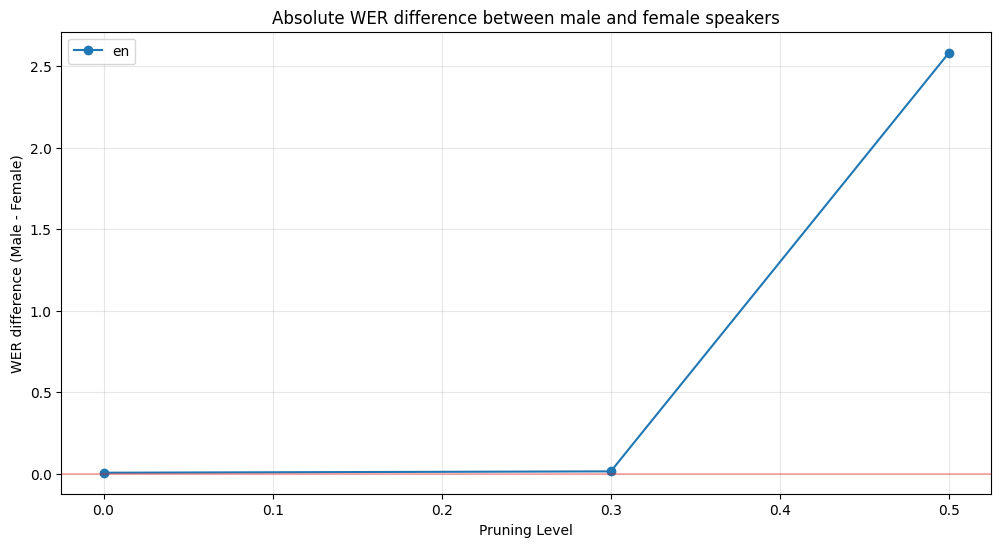

In [ ]:
def analyze_gender_discrepancies(results):
    """Analyze WER differences between genders across pruning levels."""
    summary = {}

    for lang in results:
        lang_summary = []

        for level in results[lang]:
            male_wer = results[lang][level]['male']['wer'].mean()
            female_wer = results[lang][level]['female']['wer'].mean()

            # Calculate absolute difference (as in Figure 5 of the paper)
            abs_diff = male_wer - female_wer

            # Calculate relative difference (as in Figure 4 of the paper)
            rel_diff = (male_wer - female_wer) / ((male_wer + female_wer) / 2) * 100

            lang_summary.append({
                'pruning_level': level,
                'male_wer': male_wer,
                'female_wer': female_wer,
                'abs_diff': abs_diff,
                'rel_diff': rel_diff
            })

        summary[lang] = pd.DataFrame(lang_summary)

    return summary

# Generate discrepancy analysis
discrepancy_analysis = analyze_gender_discrepancies(results)

# Plot the results (similar to Figure 4 and 5 in the paper)
import matplotlib.pyplot as plt

# Plot absolute differences
plt.figure(figsize=(12, 6))
for lang in languages:
    plt.plot(
        discrepancy_analysis[lang]['pruning_level'],
        discrepancy_analysis[lang]['abs_diff'],
        marker='o',
        label=lang
    )

plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Pruning Level')
plt.ylabel('WER difference (Male - Female)')
plt.title('Absolute WER difference between male and female speakers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

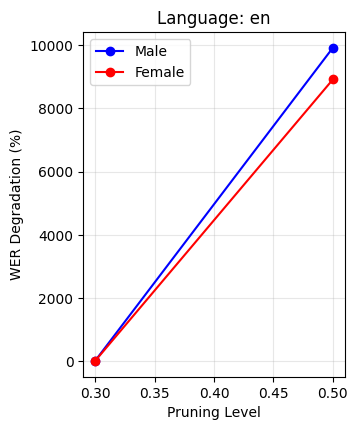

In [ ]:
def analyze_pruning_impact(results):
    """Analyze how pruning affects each gender group."""
    impact_summary = {}

    for lang in results:
        gender_impact = {'male': [], 'female': []}

        # Get baseline (unpruned) performance
        baseline_male_wer = results[lang][0]['male']['wer'].mean()
        baseline_female_wer = results[lang][0]['female']['wer'].mean()

        for level in pruning_levels:
            if level == 0:  # Skip baseline
                continue

            male_wer = results[lang][level]['male']['wer'].mean()
            female_wer = results[lang][level]['female']['wer'].mean()

            # Calculate relative degradation
            male_degradation = (male_wer - baseline_male_wer) / baseline_male_wer * 100
            female_degradation = (female_wer - baseline_female_wer) / baseline_female_wer * 100

            gender_impact['male'].append({
                'pruning_level': level,
                'wer': male_wer,
                'degradation': male_degradation
            })

            gender_impact['female'].append({
                'pruning_level': level,
                'wer': female_wer,
                'degradation': female_degradation
            })

        impact_summary[lang] = {
            'male': pd.DataFrame(gender_impact['male']),
            'female': pd.DataFrame(gender_impact['female'])
        }

    return impact_summary

# Generate pruning impact analysis
pruning_impact = analyze_pruning_impact(results)

# Plot the degradation for each gender
plt.figure(figsize=(12, 8))

for i, lang in enumerate(languages):
    plt.subplot(2, 4, i+1)
    plt.plot(
        pruning_impact[lang]['male']['pruning_level'],
        pruning_impact[lang]['male']['degradation'],
        marker='o', label='Male', color='blue'
    )
    plt.plot(
        pruning_impact[lang]['female']['pruning_level'],
        pruning_impact[lang]['female']['degradation'],
        marker='o', label='Female', color='red'
    )
    plt.title(f'Language: {lang}')
    plt.xlabel('Pruning Level')
    plt.ylabel('WER Degradation (%)')
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()